Step 1: Setup and Data Preparation


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses, optimizers
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape, Dropout, InputLayer)
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.models import Model, Sequential
%matplotlib inline

# GPU setup

physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Load Fashion MNIST data


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension ... warum ? Convolutional Neural Network braucht 3D-input (Channel)
train_images = train_images.astype('float32')  # Convert to float32
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)  # Convert labels to one-hot vectors

Step 2: Build the Generator
The generator will take a noise vector and a label as input and generate an image corresponding to the label.

In [3]:
def build_generator():
    model = Sequential()
    model.add(InputLayer(input_shape=(110,))) # 100 latent_space + 10-on-hot labels = 110
    model.add(Dense(7 * 7 * 256, activation='relu'))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))
    return model

Step 3: Build the Discriminator
The discriminator will take an image and its corresponding label as input and output a single scalar value representing the probability that the input is real.

In [4]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 11)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

Step 4: Combine Noise and Labels
We need a function to combine noise vectors and labels.

In [5]:
def combine_noise_labels(noise, labels):
    labels = tf.cast(labels, tf.float32)
    return tf.concat([noise, labels], axis=1) #Concatenates tensors along one dimension , colume to rows 


Step 5: Combine Images and Labels
We need a function to combine images and labels.

In [6]:
embedding_layer = Embedding(input_dim=10, output_dim=28*28)
reshape_layer = Reshape((28, 28, 1))

def combine_images_labels(images, labels):
    labels = tf.argmax(labels, axis=1) # from one-hot to real number 0,1,2,...9
    label_embedding = embedding_layer(labels)
    label_embedding = reshape_layer(label_embedding)
    label_embedding = tf.tile(label_embedding, [1, 1, 1, 10])
    label_embedding = tf.cast(label_embedding, tf.float32)
    return tf.concat([images, label_embedding], axis=-1)

Step 6: Loss Functions
Define the loss functions for the discriminator and generator.

In [7]:
def discriminator_loss(real_output, fake_output):
    real_loss = losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)


Step 7: Optimizers
Define the optimizers for the discriminator and generator.

In [8]:
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Step 8: Build and Compile Models
Build and compile the generator and discriminator models.

In [9]:
generator = build_generator()
discriminator = build_discriminator()

c:\Users\Mahmo\Desktop\Ai-Horsch\horsch\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\Mahmo\Desktop\Ai-Horsch\horsch\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Mahmo\Desktop\Ai-Horsch\horsch\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Step 9: Training Step
Define a single training step.

In [10]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, 100])
    combined_noise = combine_noise_labels(noise, labels)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(combined_noise, training=True)
        combined_images_real = combine_images_labels(images, labels)
        combined_images_fake = combine_images_labels(generated_images, labels)

        real_output = discriminator(combined_images_real, training=True)
        fake_output = discriminator(combined_images_fake, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Step 10: Train the Model
Define the training loop and train the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


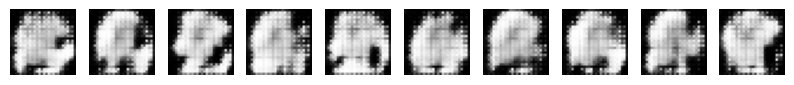

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


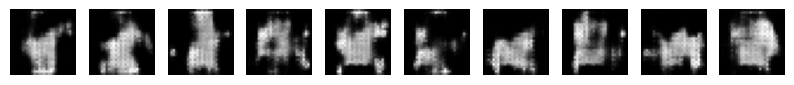

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


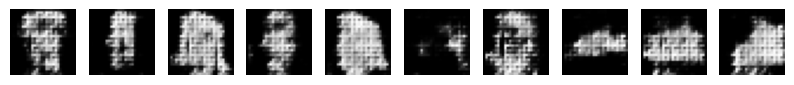

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


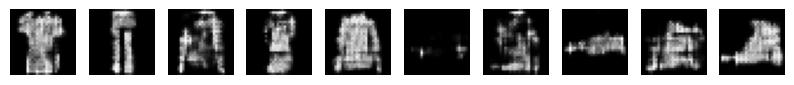

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


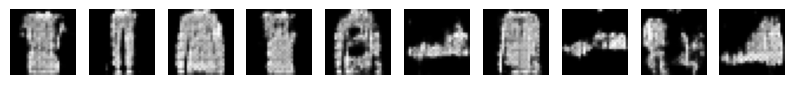

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


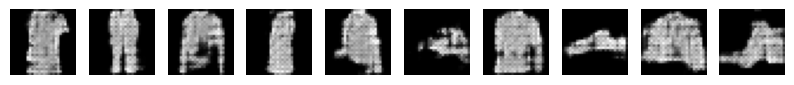

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


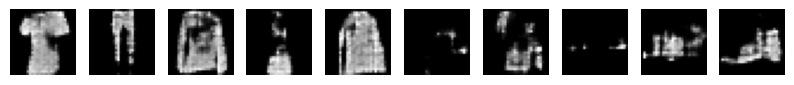

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


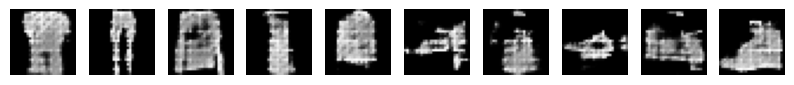

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


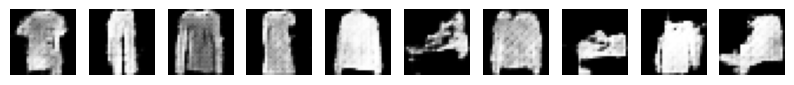

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


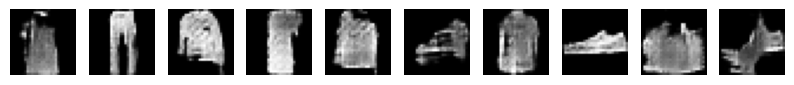

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


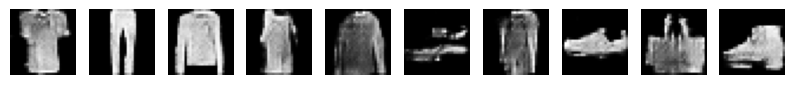

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


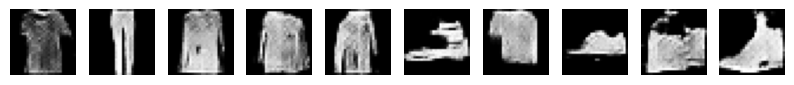

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


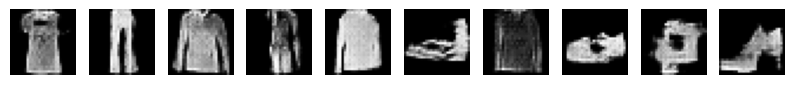

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


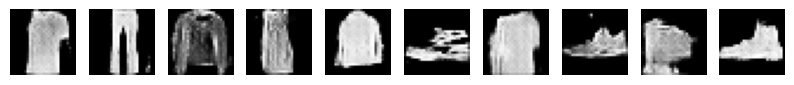

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


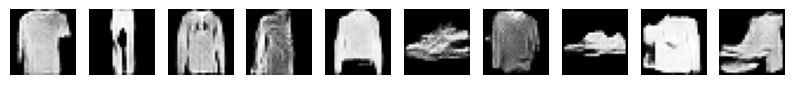

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


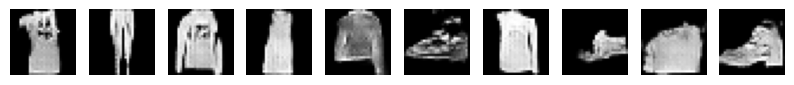

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


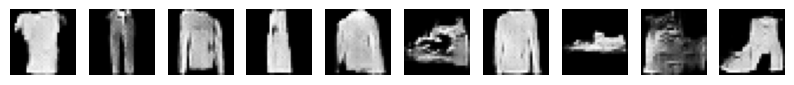

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


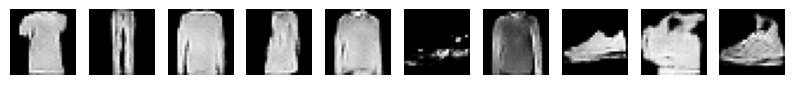

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


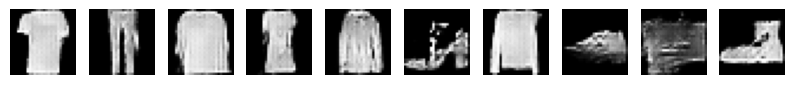

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


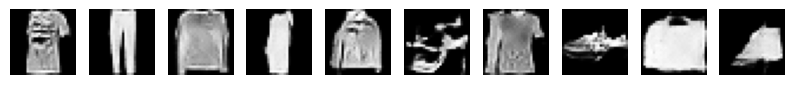

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


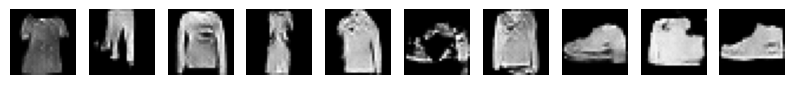

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


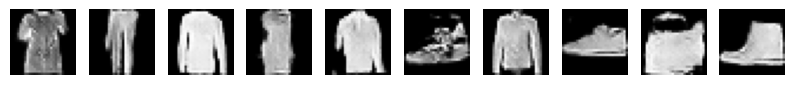

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


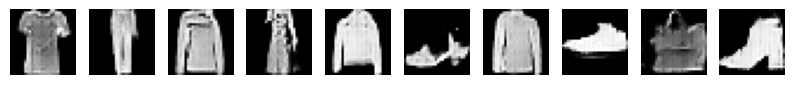

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


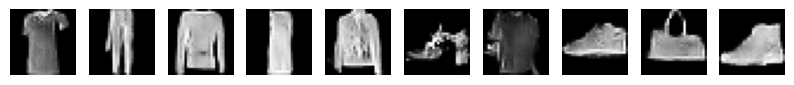

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


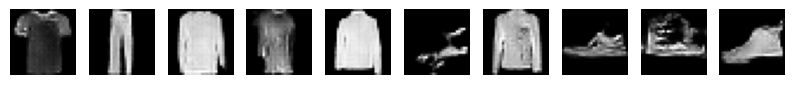

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


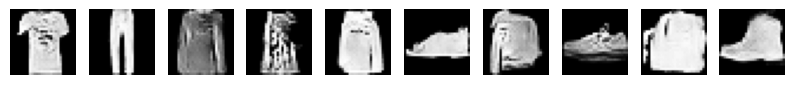

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


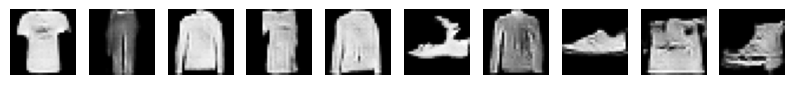

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


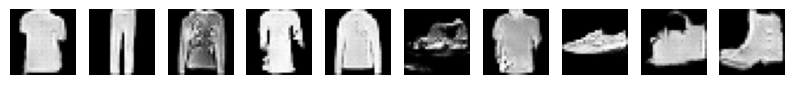

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


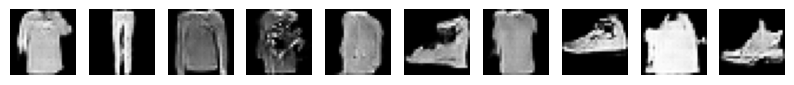

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


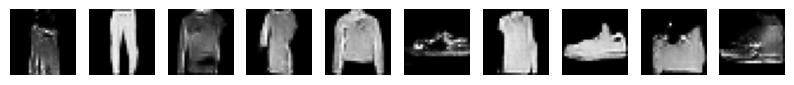

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


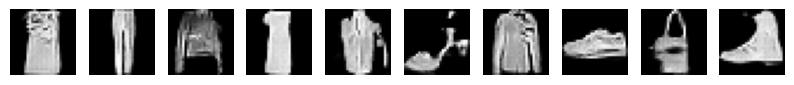

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


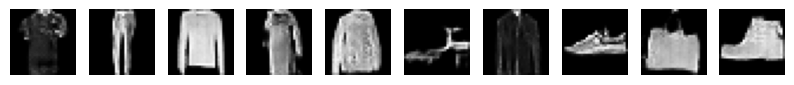

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


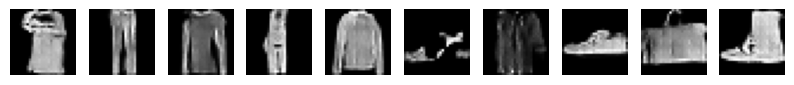

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


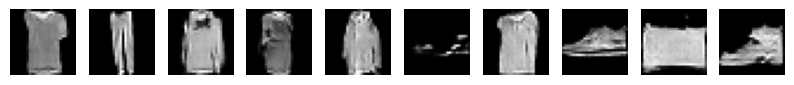

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


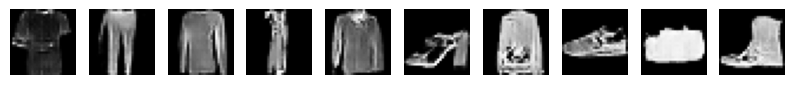

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


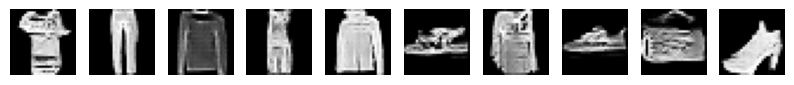

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


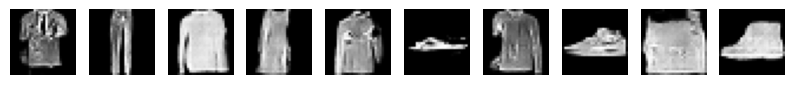

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


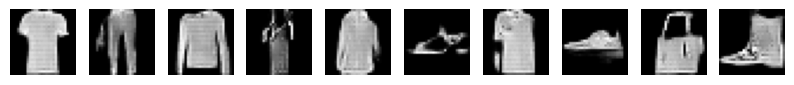

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


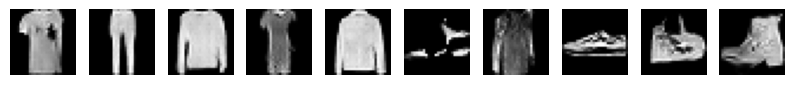

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


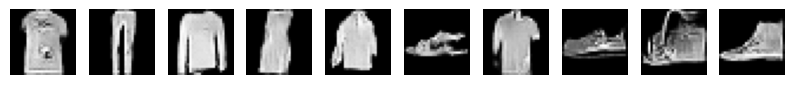

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


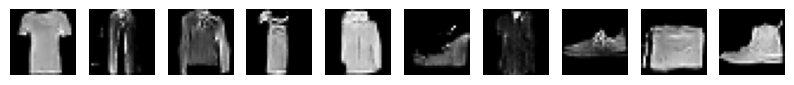

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


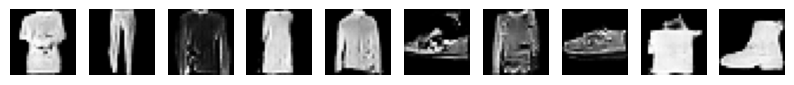

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


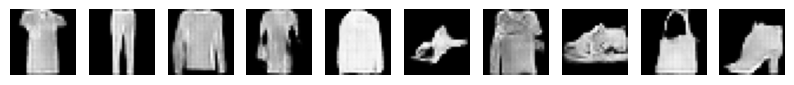

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


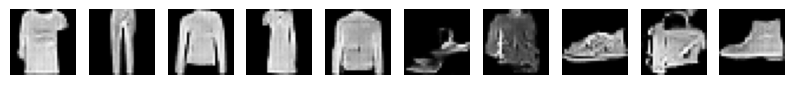

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


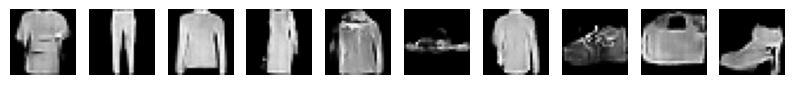

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


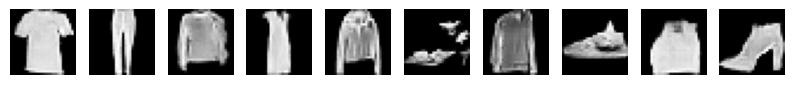

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


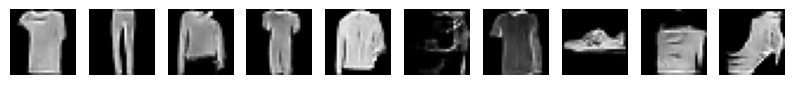

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


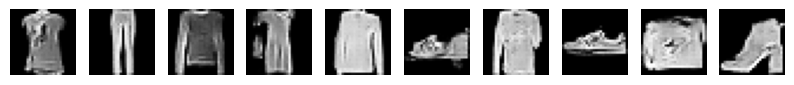

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


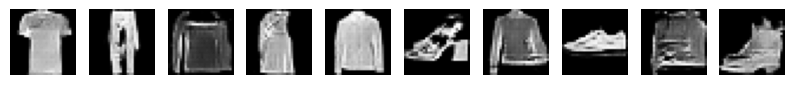

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


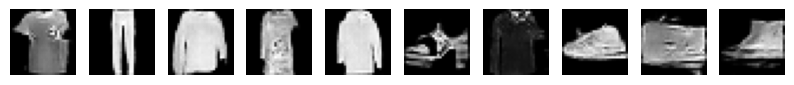

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


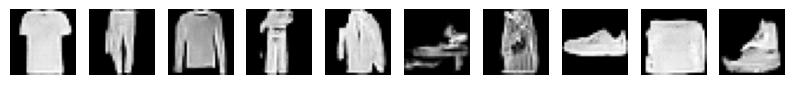

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


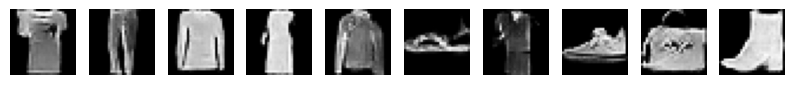

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


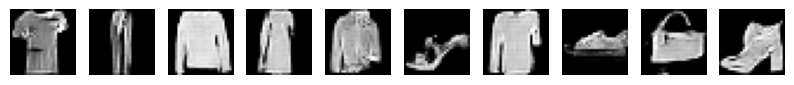

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


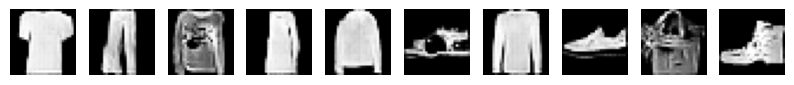

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


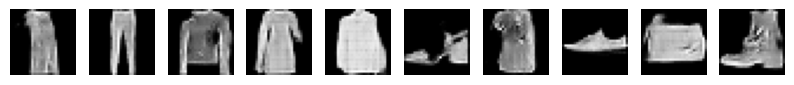

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


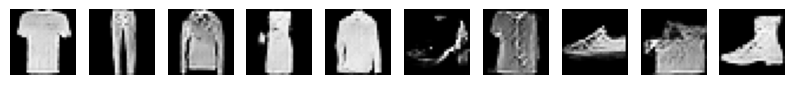

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


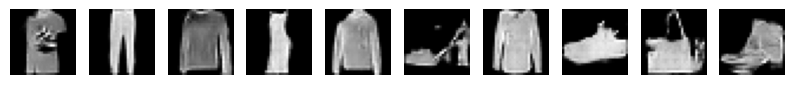

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


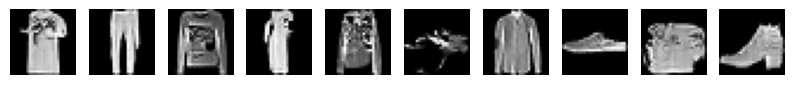

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


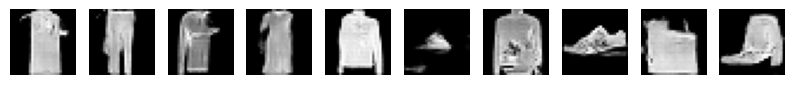

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


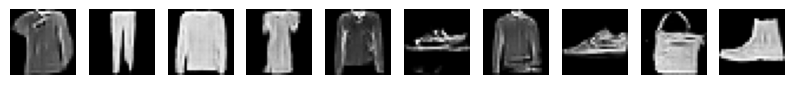

In [11]:
EPOCHS = 60
BATCH_SIZE = 128

for epoch in range(EPOCHS):
    for i in range(len(train_images) // BATCH_SIZE):
        images_batch = train_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        labels_batch = train_labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        train_step(images_batch, labels_batch)

# Generate images at the end of each epoch
    noise = tf.random.normal([10, 100])
    labels = tf.one_hot(range(10), 10)
    combined_noise = combine_noise_labels(noise, labels)
    generated_images = generator.predict(combined_noise)

# Display generated images
    fig = plt.figure(figsize=(10, 1))
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(generated_images[j, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

Step 11: Generate and Display Images
Define a function to generate and display an image for a specific label.

In [12]:
def generate_and_display(label):
    noise = tf.random.normal([1, 100])
    label_vector = tf.one_hot([label], 10)
    combined_noise = combine_noise_labels(noise, label_vector)
    generated_image = generator.predict(combined_noise)

    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

Generate and display an image for a specific label (e.g., label 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


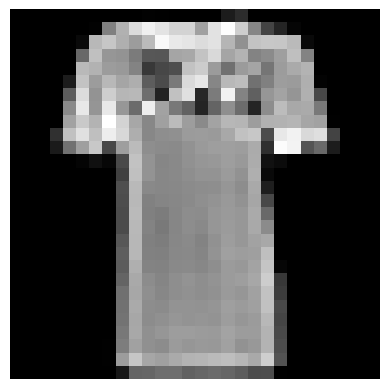

In [36]:
generate_and_display(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


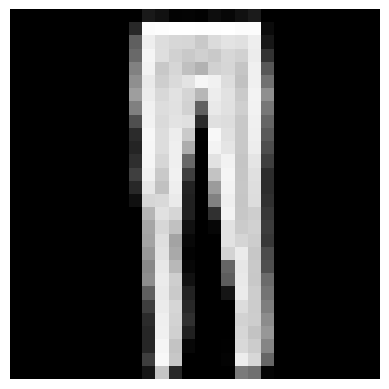

In [39]:
generate_and_display(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


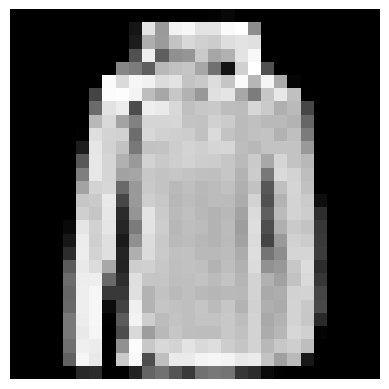

In [42]:
generate_and_display(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


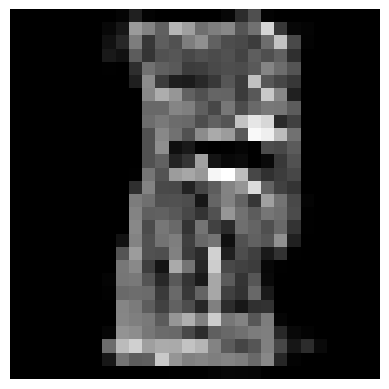

In [17]:
generate_and_display(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


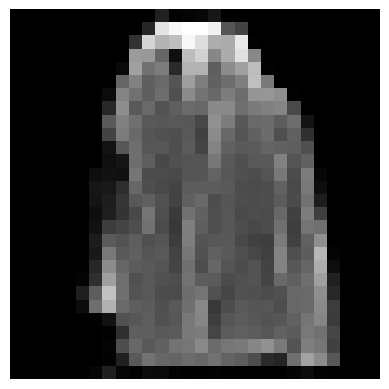

In [18]:
generate_and_display(4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


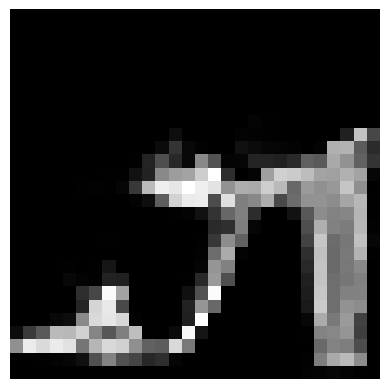

In [19]:
generate_and_display(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


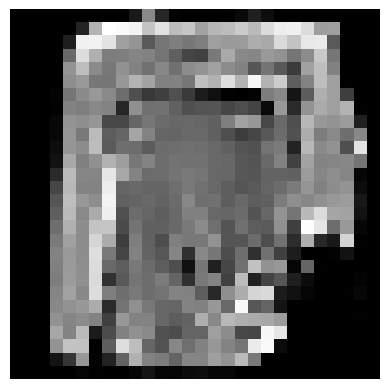

In [20]:
generate_and_display(6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


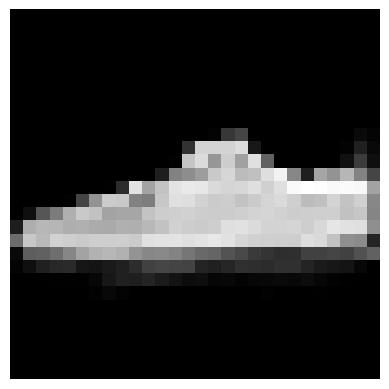

In [21]:
generate_and_display(7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


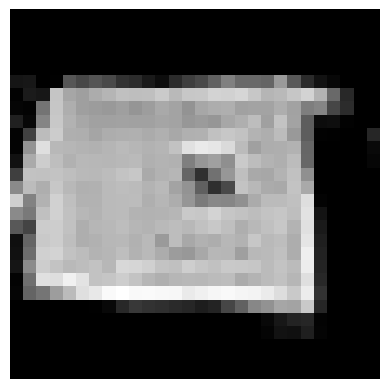

In [48]:
generate_and_display(8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


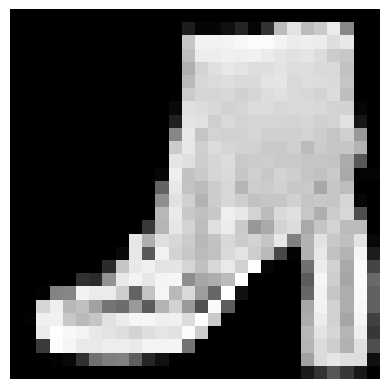

In [33]:
generate_and_display(9)